# TFG: Notebook 2: 

Questions to answer:
   - How many images have text?
       - Out of these, how many are blurred?


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy  as np
import cv2
import random
import json
import pprint

In [2]:
source = '/media/arcas/PEN/train/'
direc = '../data/'
file = "vizwiz_skill_typ_train.csv"
data = pd.read_csv(direc + file,)

## Data cleaning

In [3]:
cleaned_data = data.dropna(axis='columns')
display(cleaned_data.head())
print(f"Dataset size: {cleaned_data.shape}")

,IMG,QSN,TXT,OBJ,COL,CNT,OTH
0,VizWiz_train_00000000.jpg,What's the name of this product?,4,3,0,0,0
1,VizWiz_train_00000001.jpg,Can you tell me what is in this can please?,2,5,1,1,0
2,VizWiz_train_00000002.jpg,Is this enchilada sauce or is this tomatoes? ...,4,3,1,0,0
3,VizWiz_train_00000003.jpg,What is the captcha on this screenshot?,4,2,1,1,0
4,VizWiz_train_00000004.jpg,What is this item?,3,5,1,0,0


Dataset size: (14239, 7)


In [4]:
interest_col = ["IMG", "QSN", "TXT"]
interest_data = cleaned_data[interest_col]

## How many images have text?
We find the images in the dataset that have **more than 3 votes**, those will be the ones that contain text

In [5]:
df_w_3vts = interest_data[interest_data["TXT"] >= 3]
imgs_w_txt = df_w_3vts["IMG"].to_list()
n_imgs_w_txt = df_w_3vts.shape[0]
total_percent_img_w_txt = (n_imgs_w_txt / interest_data.shape[0]) * 100
print(f"{n_imgs_w_txt}/{interest_data.shape[0]} = {round(total_percent_img_w_txt, 2)}%")

6410/14239 = 45.02%


### Blurred
Out of the images containing text, find how many of those are blurried

<u>**2 approaches:**</u>

#### Automatic approach
Given a threshold, find which images are blurried using OpenCV

In [6]:
def blur_detector(img_path, thr=100):
    image = cv2.imread(img_path)
    b = cv2.Laplacian(image, cv2.CV_64F).var()
    if b <= thr: return img_path

**Testing threshold manually**

In [7]:
t_thr = []

for img in imgs_w_txt:
    blrd_img = blur_detector(source + img, thr=70)
    if blrd_img:
        t_thr.append(blrd_img)


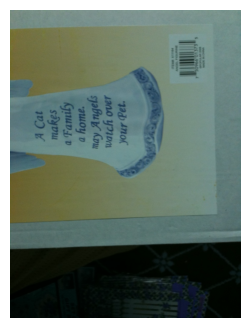

In [8]:
r = random.randint(0, len(t_thr))
random_img = t_thr[r]
plt.figure(figsize=(4, 4))
img = cv2.imread(random_img)

plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
blurred_imgs_labels = []

# For every img contaning text, check if it's blurred, if so append to list
for img in imgs_w_txt:
    blrd_img = blur_detector(source + img)
    if blrd_img:
        blurred_imgs_labels.append(blrd_img)
        
p_imtg_blrd = round((len(blurred_imgs_labels) / len(imgs_w_txt)) * 100, 2)

print(f"{len(blurred_imgs_labels)} images blurred out of {len(imgs_w_txt)} ≈ {p_imtg_blrd}%")

#### Dataset Accessing approach
There are 8 types of flaws

In [ ]:
train_json_qlty = '/media/arcas/PEN/quality.json'

with open(train_json_qlty, encoding='UTF-8') as json_file:
    data = json.load(json_file)
    data = data["train"]
    print(data.keys())
    
data_size = len(data["flaws"])
print(f"Dataset size: {data_size}")

In [ ]:
flaw_data = np.hstack(data["flaws"])
# Array with all flaw data (8 types)
arr_flaw_data = np.array(flaw_data.reshape(23431,8), dtype=bool)
# Array with all images names
arr_all_images = np.array(data["image"], dtype=str)
print(arr_flaw_data.shape)
print(arr_all_images.shape)

In [ ]:
# From the previous dataset, array containing all images with text
arr_imgs_w_txt = np.array(imgs_w_txt, dtype=str)

In [ ]:
print(arr_all_images.shape)
print(arr_imgs_w_txt.shape)

In [ ]:
# Make sure arrays are the same lenght
diff = (arr_all_images.shape[0] - arr_imgs_w_txt.shape[0])
nones = np.array([np.nan] * diff)
arr_imgs_w_txt_sized = np.concatenate((arr_imgs_w_txt, nones))
print(arr_all_images.shape)
print(arr_imgs_w_txt_sized.shape)

In [ ]:
# De todas las imagenes, indices de las imagenes con texto
all_filt = np.where(np.in1d(arr_all_images, arr_imgs_w_txt_sized))

# Array con los flaws de las imagenes con texto
arr_flaw_data_txt = arr_flaw_data[all_filt]

# Filtrar los flaws de manera que hayan imagenes blurred y recognizable
blur_index = np.where((arr_flaw_data_txt[:, 1] == True) & (arr_flaw_data_txt[:, 7] == False))

# Obtener las imagenes con texto y blur
txt_n_blur_imgs = arr_all_images[blur_index]

In [ ]:
# Stats
n_txt_and_blur_imgs = len(txt_n_blur_imgs)
p_imtg_blrd_n_text = (len(txt_n_blur_imgs) / data_size) * 100
print(f"{len(txt_n_blur_imgs)}/{data_size} = {round(p_imtg_blrd_n_text, 2)}% are text-blurried images")

In [ ]:
# De les imatges amb text, com de frequents son els diversos flaws

interest_flaws = {2 : "BRT", 3 : "DRK", 6 : "ROT"}

for i, flaw in interest_flaws.items():
    n_imgs_flaw = np.count_nonzero(arr_flaw_data_txt[:, i])
    p = (n_imgs_flaw / arr_flaw_data_txt.shape[0]) * 100
    print(f"{n_imgs_flaw} {flaw} imgs = {round(p, 2)}%")

Image visualizer

In [ ]:
nrow, ncol = 4, 4
_, axs = plt.subplots(nrow, ncol, figsize=(8, 8))
axs = axs.flatten()
for img, ax in zip(txt_n_blur_imgs, axs):
    img = cv2.imread(source + img)
    imgc = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(imgc)
    ax.axis('off')
plt.show()